# Scoring for each latent dimension & select best one for fine-grained (manually)

- rank and compare each combination
- find "best" latentSize (with their respective best HP)

In [17]:
import os
import pandas as pd
import numpy as np 
import torch
import pickle
from data.prepareData import prepareDataLoader_fromPkl
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.summary.summary_iterator import summary_iterator

pd.set_option('display.max_columns', 0)

In [18]:
def getValLoss(name):
    for file in os.listdir(f"{name}"):
        if file.startswith("events"):
            val_loss = []
            try:
                for summary in summary_iterator(f"{name}/{file}"):
                    if summary.summary.value:
                        if summary.summary.value[0].tag == "Val - Loss":
                            val_loss.append(summary.summary.value[0].simple_value)
            except UnboundLocalError:
                print("error during val loss scoring")
    return np.array(val_loss[-10:]).mean()

def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return np.array(pearson).mean()

def getScores(path, test_tensor, dict_scoring, save=True):

    ### Load model
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
              
    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)   

    try: 
        dict_scoring["chr"].append(CHR)
        dict_scoring["latSize"].append(path.split("/")[-1].split("_")[1])
        dict_scoring["lr"].append(path.split("/")[-1].split("_")[3])   
        dict_scoring["dropr"].append(path.split("/")[-1].split("_")[5])
        dict_scoring["pearson_mean"].append(getPearsonR(orig=test_tensor, recon=recon))
        #name = f"logs/{path}"    ##### THIS IS THE WORNG PATH FOR THE FUTURE! remove logs    
        dict_scoring["loss_mean"].append(getValLoss(path))
    except RuntimeWarning: 
        print("error")
        
    return dict_scoring

def getRanking(dict_scores):
    df = pd.DataFrame.from_dict(dict_scoring, orient="index").T

    ## Rank Pearson reconstruction accuracy - higher values better; 1 is best!
    df = df.sort_values("pearson_mean", ascending=False)
    df["pearson_mean"].replace(np.nan,0, inplace=True)
    df["idx_pearson"] = range(1,len(df)+1)

    ## Rank val loss - lower values better; 1 is best!
    df = df.sort_values("loss_mean", ascending=True)
    df["idx_loss"] = range(1,len(df)+1)

    ## Calcualte mean() ranking --> the lower the better (balance between loss and recon acc)
    df["idx_mean"] = df[["idx_pearson", "idx_loss"]].mean(axis=1)
    df = df.sort_values("idx_mean", ascending=True)
    return df

In [19]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"

## Get scores for each latFeature

In [70]:
for CHR in ["chr22"]:#["chr20"]:
    ### Load data
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    ### Get runs for each latSize individually
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    print(LATSIZES)
    
    for LATSIZE in LATSIZES:
        print(LATSIZE)
        ### Initialise results dict
        dict_scoring = dict()
        for key in ["chr", "latSize", "lr", "dropr", "pearson_mean", "loss_mean"]:
            dict_scoring[key] = []
        ### Parse over fodler to get runs
        try: 
            for folder in os.listdir(PATH_results):
                if folder.startswith(f"latSize_{LATSIZE}"):
                    ### Get scores in dict
                    path = f"{PATH_results}/{folder}"
                    dict_final_scores = getScores(path, 
                                            test_tensor, 
                                            dict_scoring)
            ### Save scoring dict for later use
            with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "w") as f: json.dump(dict_final_scores, f, indent=4)
        except FileNotFoundError:
            print(f"\t{folder}\t: FileNotFoundError (not finished)")
        except UnboundLocalError:
            print(f"\t{folder}\t: UnboundLocalError")

[160, 80, 40, 20, 10, 5]
160
80
40
20
10
5


In [58]:
#dict_scores

# Get ranking for each latFeature

In [73]:
for CHR in ["chr22"]: #["chr20"]:   
    df_summary = pd.DataFrame()
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    for LATSIZE in LATSIZES:
        ### Lod scoring for each latSize
        try:
            with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "r") as f: dict_scoring = json.load(f)
        except FileNotFoundError:
            print(f"file missing: scoring_latSize_{LATSIZE}.json - SKIP")
        ### Do the ranking over all runs with one latent size
        df_ranking = getRanking(dict_scoring)
        df_summary = pd.concat([df_summary, df_ranking], ignore_index=True)
    df_summary.to_csv(f"{PATH_results}/scoring+ranking.csv", index=False)

# Plot & manually select best latSize

[160  80  40  20  10   5]


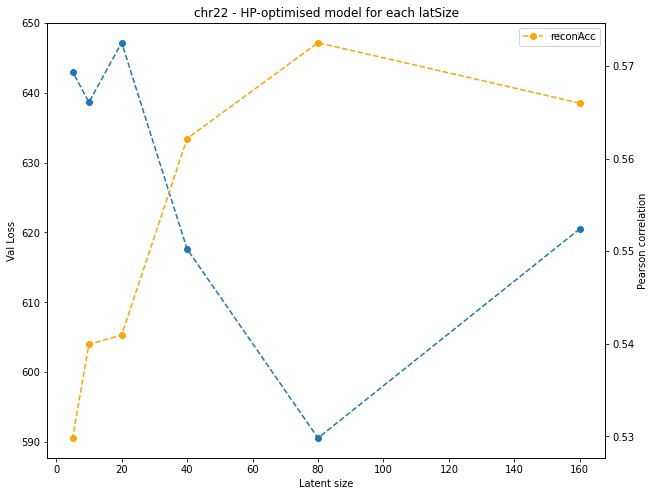

In [74]:
CHR = "chr22"
PATH_results = f"logs/optimisation/{CHR}/coarse"
df_summary = pd.read_csv(f"{PATH_results}/scoring+ranking.csv")
LATSIZES = df_summary["latSize"].unique()

latSizes_loss = [df_summary[df_summary["latSize"] == LATSIZE].iloc[0,5] for LATSIZE in LATSIZES]
latSizes_pearson = [df_summary[df_summary["latSize"] == LATSIZE].iloc[0,4] for LATSIZE in LATSIZES]

print(LATSIZES)

fig, ax = plt.subplots(figsize=(10,8))
fig.patch.set_alpha(1)
ax.plot(LATSIZES, latSizes_loss, '--o', label="loss")
ax.set_ylabel("Val Loss")
ax2 = ax.twinx()
ax2.plot(LATSIZES, latSizes_pearson, "--o",c="orange", label="reconAcc")
ax2.set_ylabel("Pearson correlation")
ax.set_xlabel("Latent size")
ax.set_title(f"{CHR} - HP-optimised model for each latSize")
ax2.legend()
ax.legend()
fig.savefig(f"{PATH_results}/latSizeComparison.png")

## Manual:

In [75]:
### Determine best model 
print(CHR+"\n")
BEST_LAT = 80
df_best = df_summary[df_summary["latSize"] == BEST_LAT].iloc[0,]
print(df_best)

### save in file 
dict_bestLat = {}
dict_bestLat["chr"] = df_best["chr"]
dict_bestLat["latSize"] = str(df_best["latSize"])
dict_bestLat["lr"] = df_best["lr"]
dict_bestLat["dropr"] = df_best["dropr"]

PATH_results = f"logs/optimisation/{CHR}/coarse"
with open(f"{PATH_results}/best_model_coarseOptimization.json", "w") as f: json.dump(dict_bestLat, f, indent=4)
print("\n\nSaved!")

chr22

chr                  chr22
latSize                 80
lr                  0.0005
dropr                  0.3
pearson_mean      0.572536
loss_mean       590.569916
idx_pearson              1
idx_loss                 1
idx_mean               1.0
Name: 12, dtype: object


Saved!


## Remove all .pth files of coarse grained search
to save some space on the cluster

# Sanity check: Chr22 now & before

In [ ]:
### compare chr22 with old chr22!! --> wiht old HP same results?

In [40]:
for CHR in ["chr22"]: #["chr20"]:   
    df_summary = pd.DataFrame()
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    for LATSIZE in LATSIZES:
        ### Lod scoring for each latSize
        with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "r") as f: dict_scoring = json.load(f)
        ### Do the ranking over all runs with one latent size
        df_ranking = getRanking(dict_scoring)
        df_summary = pd.concat([df_summary, df_ranking], ignore_index=True)
    df_summary.to_csv(f"{PATH_results}/scoring+ranking.csv", index=False)


|                    | layers   | lr     | dropr | pearson_mean | loss_mean  |   |
|--------------------|----------|--------|-------|--------------|------------|---|
| HP_opt: latSize=20 | 1570,310 | 0.0005 | 0.3   | 0.540938     | 647.171844 |   |
| old: latSize=25    | 2000,500 | 0.0001 | 0.3   | 0.532        | 621.334314 |   |
| HP_opt: latSize=20 | 1570,310 | 0.0001 | 0.3   | 0.516324     | 629.472815 |   |

In [38]:
print(LATSIZES)
df_summary[df_summary["latSize"] == "80"]   ### best 	0.0005	0.3	0.540938	647.171844

[160, 80, 40, 20, 10, 5]


,chr,latSize,lr,dropr,pearson_mean,loss_mean,idx_pearson,idx_loss,idx_mean
12,chr22,80,0.0005,0.3,0.572536,590.569916,1,1,1.0
13,chr22,80,0.0005,0.1,0.56922,621.987152,2,3,2.5
14,chr22,80,0.0005,0.5,0.560358,610.29422,5,2,3.5
15,chr22,80,0.001,0.1,0.560525,667.110992,4,6,5.0
16,chr22,80,0.001,0.5,0.555665,646.614349,6,5,5.5
17,chr22,80,0.001,0.3,0.560709,709.030536,3,9,6.0
18,chr22,80,0.0001,0.1,0.510484,642.674866,9,4,6.5
19,chr22,80,0.005,0.3,0.520312,691.689319,8,8,8.0
20,chr22,80,0.005,0.1,0.544053,769.482849,7,10,8.5
21,chr22,80,0.005,0.5,0.498032,676.088794,11,7,9.0
